In [15]:
import os
import os.path
import cv2
import math
import numpy as np
from numpy import random
from matplotlib import pyplot as plt

The general aim of the work is to write a Python library which helps to detect specific Tetris-like shapes in any given image. The library must provide two functions: detect_shapes, detect_colors. 

# Shape detection problem


The aim is to detect different variations of specific Tetris-like shapes. We have five distinct shapes:

1. Linear shape
2. L-like shape
3. Square shape
4. Z-like shape
6. T-like shape

We also must include variations of the shapes: 

- rotation by 90 degrees 
- and flipping. 

Some shapes are fully rotation and flipping invariant, like the square shape, some are partially invariant, like the linear shape. Finally, we have to recognize the following variations of the specified shapes:

1. Linear: 2 variations from rotation, 0 from flipping
2. L: 4 variations from rotation, 4 from flipping
3. Square: 1 variation from rotation, 0 from flipping
5. Z: 2 variations from rotation, 2 from flipping
6. T: 4 variations from rotation, 0 from flipping

In total we have to recognize 13+6=19 shapes.

To approach the problem we are using the template matching technique[1] which is implemented in the OpenCV library. The technique requires a template which is slided through the given image and compared to the current region. The metric is computed for each pixel representing the similarity of the patch with the region. The higher the metric the more probability of finding the match. By applying some threshold we can decide if we consider the given output metrics as a successful match or not.

Our method requires the following steps:

1. creating definitions of templates
2. comparing the templates with the image
3. applying the threshold to decide if the matches are successful
4. count successful matches for each template and group them by distinct shapes

---
1: https://www.docs.opencv.org/2.4/doc/tutorials/imgproc/histograms/template_matching/template_matching.html

## 1. Creating definitions of templates

To create all variations of templates we have used a graphics editing software and saved them as images. Using the following code we can load them into the library and use further for matching.

In [2]:
# getting template paths from the directory
template_paths = []
for path in os.listdir('data/templates'):
    # skipping non-image files
    if '.jpg' not in path:
        continue
    template_paths.append('data/templates/' + path)

# reading all templates
templates = []
for path in template_paths:
    # skipping non-image files
    if '.jpg' not in path:
        continue
    # reading an image in grayscale
    templates.append(cv2.imread(path, 0))

# parsing paths to group templates by distinct shapes, at the end we have a dict: {shape_name: [templates]}
templates_dict = {}
for i in range(len(template_paths)):
    path = template_paths[i]
    key = (lambda path: os.path.splitext(os.path.basename(path)))(path)[0].split('_')[0]  # sorry for this line
    if templates_dict.get(key):
        templates_dict[key].append(templates[i])
    else:
        templates_dict[key] = [templates[i]]

Then we can visualize all variants of templates we have acquired:

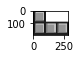

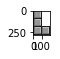

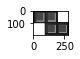

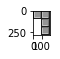

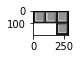

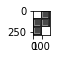

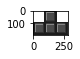

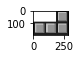

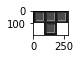

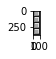

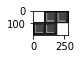

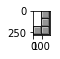

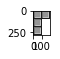

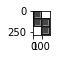

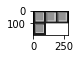

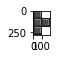

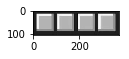

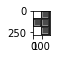

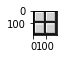

In [3]:
n = len(templates)
for i in range(n):
    plt.figure(figsize=(10,10))
    plt.subplot(n,1,i+1)
    plt.imshow(templates[i], cmap='gray')

## 2. Comparing the templates with the image and deciding about the successful match

As we described above we use the OpenCV function `matchTemplate` to compare the templates with the image applying the normalized cross-coefficient method for calculating the metric of similarity. The cross-coefficient measures the similarity between two matrices and the normalization gives us the possibility to conveniently apply threshold to decide about the successful match. The normalization gives us computed metrics in the range of [-1,1].

In [6]:
def detect_shapes_locations(img, template, threshold=0.8):
    """Finds matches of the template on the image. 
    Returns locations of all found points.
    """
    w, h = template.shape[::-1]
    rv = cv2.matchTemplate(img, template, cv2.TM_CCOEFF_NORMED)
    loc = np.where(rv >= threshold)
    return loc

def highlight_detected_shapes(img, tpl, loc):
    """Draws the image with highlighted locations of the detected shapes and the template itself.
    """
    if len(loc[0]) == 0:
        return img
    
    w, h = tpl.shape[::-1]
    out = None
    for point in zip(*loc[::-1]):
        out = cv2.rectangle(img, point, (point[0] + w, point[1] + h), (0,0,255), 20)
        
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.imshow(out, cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(tpl, cmap='gray')

We can test the code above on a single image

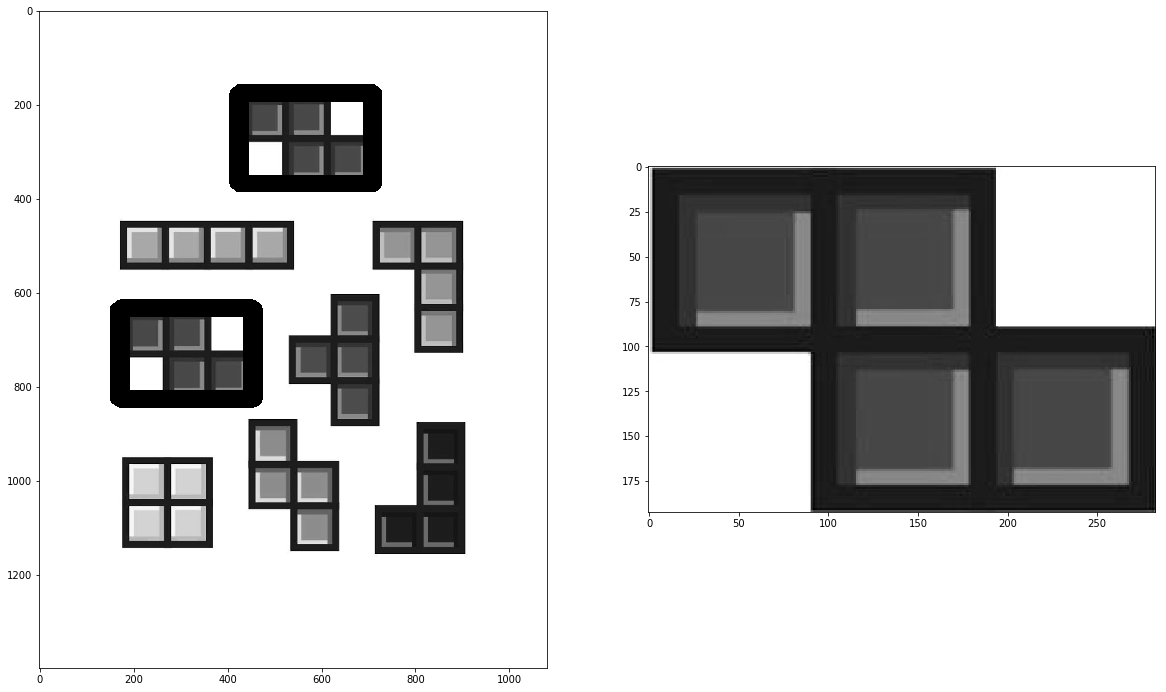

In [7]:
img = cv2.imread('data/test_2.jpg', 0)
tpl = templates[2]
loc = detect_shapes_locations(img, tpl)
highlight_detected_shapes(img, tpl, loc)

## 3. Counting successful matches

Given the locations of successfule matches we have to find clusters of points which correspond to the matched shapes. To approach this problem we can study plots and histograms of locations:

(array([217.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 217.]),
 array([167.  , 190.75, 214.5 , 238.25, 262.  , 285.75, 309.5 , 333.25,
        357.  , 380.75, 404.5 , 428.25, 452.  , 475.75, 499.5 , 523.25,
        547.  , 570.75, 594.5 , 618.25, 642.  ]),
 <a list of 20 Patch objects>)

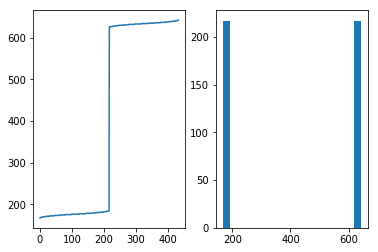

In [182]:
plt.figure()
plt.subplot(1, 2, 1)
# plotting pixels positions over the index in the matrix
plt.plot(list(range(len(loc[0]))), loc[0])
plt.subplot(1, 2, 2)
# plotting the histogram of pixels positions
plt.hist(loc[0], 20)

On the plots we can clearly see two clusters of points which correspond to two repeats of the same shape in the given image. To calculate the amount of clusters we compare the difference between the next location with the previous one with the threshold to decide about the boundary of the cluster. Empirically we found the value of 10 pixels good enough to separate clusters between each other.

In [8]:
def count_clusters(loc, threshold=3):
    # checking the case when there are no detections
    if len(loc[0]) == 0:
        return 0
    
    # otherwise there is at least one cluster
    clusters_y = 1
    clusters_x = 1
    
    # comparing the difference with the threshold
    for i in range(len(loc[0])-1):
        if (loc[0][i+1]-loc[0][i]) > threshold:
            clusters_y += 1
    for i in range(len(loc[1])-1):
        if (loc[1][i+1]-loc[1][i]) > threshold:
            clusters_x += 1
    
    #print('x, y', clusters_x, clusters_y)
    mu = math.ceil((clusters_x + clusters_y) / 2.0)
    return mu

In [9]:
count_clusters(loc)

2

## The final solution

We were able to find successful matches and count repeats of them in the given image. Below we are solving the final task of applying our technique to all templates and grouping the results according to distinct shapes:

In [10]:
def detect_shapes(img, threshold=3):
    global templates_dict
    
    shapes = {}
    for shape_name in templates_dict:
        for tpl in templates_dict[shape_name]:
            loc = detect_shapes_locations(img, tpl)
            n = count_clusters(loc, threshold)
            if n > 0:
                if shapes.get(shape_name):
                    shapes[shape_name] += n
                else:
                    shapes[shape_name] = n
    return shapes

The function `detect_shapes` is the only function a user of the library has to use to be able to detect Tetris-like shapes in the given image.

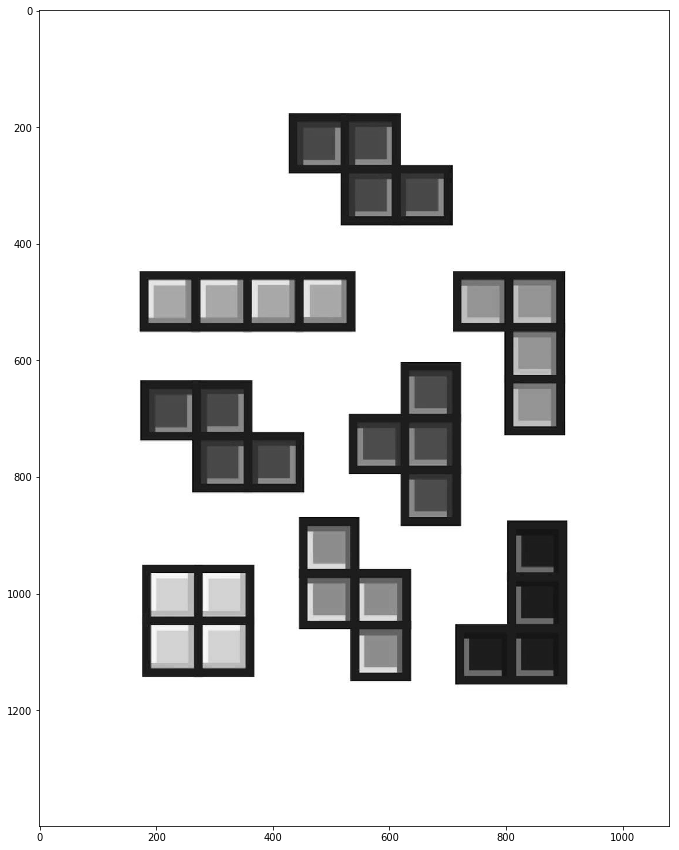

In [11]:
img = cv2.imread('data/test_2.jpg', 0)
results = detect_shapes(img)
plt.figure(figsize=(15,15))
plt.imshow(img, cmap='gray')

In [13]:
results

{'L': 2, 'Z': 3, 'T': 1, 'linear': 1, 'square': 1}